In [1]:
from backtest import ticker_stats, smooth, features, stringify, print_ticker_heading, balanced_scorecard, \
                     determine_minima_n_maxima, align_minima_n_maxima, plot_trades, split_data, \
                     get_signals, merge_buy_n_sell_signals, extract_trades, get_possible_trades, \
                     backtester
import pandas as pd
import numpy as np

from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from datetime import date, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter, argrelmin, argrelmax

import gc; gc.enable()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# suppress output of plotting all the trades as this is quite a lot...
# plot_trades(tickers, min_indices, max_indices)

In [4]:
myPnL_df, my_Capital_df = backtester()

Simulating 98 stocks
tickers= ['ADRO', 'AGRX', 'AA', 'ALXN', 'AMT', 'AMWD', 'PLAN', 'BOCH', 'BB', 'BMCH', 'BXP', 'BHF', 'BLDR', 'BFST', 'CPB', 'CBL', 'CRL', 'CVX', 'CYD', 'JVA', 'CUTR', 'CVI', 'DRI', 'DLX', 'DERM', 'DSGX', 'DVN', 'DRQ', 'EPM', 'EXLS', 'FCFS', 'FHB', 'FOR', 'RAIL', 'FEIM', 'FTEK', 'GS', 'GGG', 'GWB', 'GPRE', 'GRIF', 'GRPN', 'GURE', 'HWC', 'HLT', 'IPG', 'INVH', 'IQV', 'JELD', 'LIND', 'MIC', 'MBI', 'MEDP', 'MDP', 'VIVO', 'MLND', 'MRC', 'MVBF', 'NKSH', 'FIZZ', 'OTEX', 'OPTN', 'OPCH', 'ORC', 'OBNK', 'ORIT', 'OMI', 'PCAR', 'PANW', 'PEBK', 'PRSP', 'PSDO', 'PGR', 'PRPL', 'REGN', 'RM', 'SWM', 'SEEL', 'SIBN', 'SLG', 'SPTN', 'SPPI', 'SYX', 'TANH', 'TGT', 'TXRH', 'TTSH', 'TOWN', 'CLUB', 'TRNS', 'TGA', 'TRIP', 'ULH', 'USPH', 'VZ', 'VSH', 'WSTG', 'WBT']
Ticker: ADRO min_id= 23 max_id= 42
      ADRO min_id= 23 max_id= 42 
Ticker: AGRX min_id= 49 max_id= 27
      AGRX min_id= 49 max_id= 74  (*)
Ticker: AA min_id= 94 max_id= 27
      AA min_id= 94 max_id= 110  (*)
Ticker: ALXN min_id= 

Days to simulate: 982
*** buying ORIT on 2017-01-23 00:00:00 with target sell date of 2017-02-01 00:00:00
*** selling ORIT on 2017-02-01 00:00:00
profit of selling ORIT on 2017-02-01 00:00:00:  38.5164051355207 1.93%
*** buying ORIT on 2017-02-08 00:00:00 with target sell date of 2017-02-15 00:00:00
*** selling ORIT on 2017-02-15 00:00:00
profit of selling ORIT on 2017-02-15 00:00:00:  18.43230413372339 0.92%
*** buying ORIT on 2017-03-13 00:00:00 with target sell date of 2017-10-12 00:00:00
*** buying BOCH on 2017-03-16 00:00:00 with target sell date of 2017-03-22 00:00:00
*** buying CPB on 2017-03-16 00:00:00 with target sell date of 2017-05-26 00:00:00
*** buying CVX on 2017-03-17 00:00:00 with target sell date of 2017-05-10 00:00:00
*** buying SYX on 2017-03-20 00:00:00 with target sell date of 2017-04-07 00:00:00
you do not have 2000.078393630015 and setting amount to 2000.078393630015
*** buying TOWN on 2017-03-20 00:00:00 with target sell date of 2017-04-27 00:00:00
maxed out: T

profit of selling CVI on 2017-05-01 00:00:00:  316.41080795026915 15.94%
*** buying MDP on 2017-05-01 00:00:00 with target sell date of 2017-07-10 00:00:00
*** buying TOWN on 2017-05-01 00:00:00 with target sell date of 2017-05-08 00:00:00
maxed out: TOWN is not expected to perform better than stocks already invested in
invested in: dict_keys(['ORIT', 'TGT', 'OPCH', 'TRNS', 'MDP']) (5)

*** buying PEBK on 2017-05-01 00:00:00 with target sell date of 2017-06-06 00:00:00
*** selling MDP on 2017-05-01 00:00:00 to free up money for PEBK
profit of selling MDP on 2017-05-01 00:00:00:  0.0 0.0%
*** buying GRIF on 2017-05-05 00:00:00 with target sell date of 2017-05-25 00:00:00
maxed out: GRIF is not expected to perform better than stocks already invested in
invested in: dict_keys(['ORIT', 'TGT', 'OPCH', 'TRNS', 'PEBK']) (5)

*** buying TGA on 2017-05-09 00:00:00 with target sell date of 2017-05-17 00:00:00
maxed out: TGA is not expected to perform better than stocks already invested in
invest

*** buying GGG on 2017-06-30 00:00:00 with target sell date of 2017-08-02 00:00:00
maxed out: GGG is not expected to perform better than stocks already invested in
invested in: dict_keys(['ORIT', 'TRNS', 'OTEX', 'TGT', 'AMWD']) (5)

*** buying WSTG on 2017-06-30 00:00:00 with target sell date of 2017-10-06 00:00:00
maxed out: WSTG is not expected to perform better than stocks already invested in
invested in: dict_keys(['ORIT', 'TRNS', 'OTEX', 'TGT', 'AMWD']) (5)

*** buying BXP on 2017-07-05 00:00:00 with target sell date of 2017-08-25 00:00:00
maxed out: BXP is not expected to perform better than stocks already invested in
invested in: dict_keys(['ORIT', 'TRNS', 'OTEX', 'TGT', 'AMWD']) (5)

*** buying VZ on 2017-07-06 00:00:00 with target sell date of 2017-08-09 00:00:00
maxed out: VZ is not expected to perform better than stocks already invested in
invested in: dict_keys(['ORIT', 'TRNS', 'OTEX', 'TGT', 'AMWD']) (5)

*** buying REGN on 2017-07-06 00:00:00 with target sell date of 2017

*** buying TRNS on 2017-08-15 00:00:00 with target sell date of 2017-10-10 00:00:00
*** selling VSH on 2017-08-15 00:00:00 to free up money for TRNS
profit of selling VSH on 2017-08-15 00:00:00:  0.0 0.0%
*** selling SYX on 2017-08-16 00:00:00
profit of selling SYX on 2017-08-16 00:00:00:  622.8324108946963 25.5%
*** buying PEBK on 2017-08-16 00:00:00 with target sell date of 2017-10-04 00:00:00
*** selling MBI on 2017-08-17 00:00:00
profit of selling MBI on 2017-08-17 00:00:00:  179.76228086016636 6.93%
*** buying GRIF on 2017-08-21 00:00:00 with target sell date of 2017-08-22 00:00:00
*** selling GRIF on 2017-08-22 00:00:00
profit of selling GRIF on 2017-08-22 00:00:00:  41.63255952588406 1.61%
*** buying DLX on 2017-08-22 00:00:00 with target sell date of 2017-08-25 00:00:00
*** buying TOWN on 2017-08-23 00:00:00 with target sell date of 2017-09-11 00:00:00
maxed out: TOWN is not expected to perform better than stocks already invested in
invested in: dict_keys(['ORIT', 'CVI', 'TRNS'

*** buying GWB on 2017-11-08 00:00:00 with target sell date of 2017-11-29 00:00:00
maxed out: GWB is not expected to perform better than stocks already invested in
invested in: dict_keys(['AMT', 'TRNS', 'DSGX', 'SLG', 'TGT']) (5)

*** buying EPM on 2017-11-08 00:00:00 with target sell date of 2017-11-20 00:00:00
maxed out: EPM is not expected to perform better than stocks already invested in
invested in: dict_keys(['AMT', 'TRNS', 'DSGX', 'SLG', 'TGT']) (5)

*** buying TOWN on 2017-11-08 00:00:00 with target sell date of 2018-03-08 00:00:00
maxed out: TOWN is not expected to perform better than stocks already invested in
invested in: dict_keys(['AMT', 'TRNS', 'DSGX', 'SLG', 'TGT']) (5)

*** buying PEBK on 2017-11-09 00:00:00 with target sell date of 2017-11-24 00:00:00
*** selling SLG on 2017-11-09 00:00:00 to free up money for PEBK
profit of selling SLG on 2017-11-09 00:00:00:  87.32496929086437 3.62%
you do not have 2677.0674744568596 and setting amount to 2677.0674744568596
*** selli

*** buying TRNS on 2018-01-04 00:00:00 with target sell date of 2018-01-29 00:00:00
*** selling MBI on 2018-01-04 00:00:00 to free up money for TRNS
profit of selling MBI on 2018-01-04 00:00:00:  98.54397787507605 3.47%
you do not have 2941.158724271498 and setting amount to 2941.158724271498
*** selling CRL on 2018-01-05 00:00:00
profit of selling CRL on 2018-01-05 00:00:00:  282.10479987075405 9.38%
*** buying TRIP on 2018-01-05 00:00:00 with target sell date of 2018-01-24 00:00:00
*** buying GRIF on 2018-01-05 00:00:00 with target sell date of 2018-01-12 00:00:00
*** selling TRIP on 2018-01-05 00:00:00 to free up money for GRIF
profit of selling TRIP on 2018-01-05 00:00:00:  0.0 0.0%
*** buying WSTG on 2018-01-08 00:00:00 with target sell date of 2018-03-20 00:00:00
maxed out: WSTG is not expected to perform better than stocks already invested in
invested in: dict_keys(['TGT', 'ORIT', 'PANW', 'TRNS', 'GRIF']) (5)

*** buying GWB on 2018-01-09 00:00:00 with target sell date of 2018-0

*** buying JVA on 2018-02-13 00:00:00 with target sell date of 2018-02-16 00:00:00
maxed out: JVA is not expected to perform better than stocks already invested in
invested in: dict_keys(['TGT', 'PANW', 'CVI', 'OPCH', 'SYX']) (5)

*** buying EXLS on 2018-02-13 00:00:00 with target sell date of 2018-03-16 00:00:00
maxed out: EXLS is not expected to perform better than stocks already invested in
invested in: dict_keys(['TGT', 'PANW', 'CVI', 'OPCH', 'SYX']) (5)

*** buying MVBF on 2018-02-13 00:00:00 with target sell date of 2018-06-06 00:00:00
maxed out: MVBF is not expected to perform better than stocks already invested in
invested in: dict_keys(['TGT', 'PANW', 'CVI', 'OPCH', 'SYX']) (5)

*** buying GWB on 2018-02-14 00:00:00 with target sell date of 2018-03-20 00:00:00
maxed out: GWB is not expected to perform better than stocks already invested in
invested in: dict_keys(['TGT', 'PANW', 'CVI', 'OPCH', 'SYX']) (5)

*** buying AMT on 2018-02-15 00:00:00 with target sell date of 2018-03-1

*** buying TGA on 2018-04-09 00:00:00 with target sell date of 2018-04-13 00:00:00
maxed out: TGA is not expected to perform better than stocks already invested in
invested in: dict_keys(['TGT', 'TRNS', 'OTEX', 'CRL', 'SYX']) (5)

*** buying BB on 2018-04-10 00:00:00 with target sell date of 2018-05-17 00:00:00
maxed out: BB is not expected to perform better than stocks already invested in
invested in: dict_keys(['TGT', 'TRNS', 'OTEX', 'CRL', 'SYX']) (5)

*** buying WSTG on 2018-04-11 00:00:00 with target sell date of 2018-05-07 00:00:00
maxed out: WSTG is not expected to perform better than stocks already invested in
invested in: dict_keys(['TGT', 'TRNS', 'OTEX', 'CRL', 'SYX']) (5)

*** buying PCAR on 2018-04-13 00:00:00 with target sell date of 2018-04-17 00:00:00
maxed out: PCAR is not expected to perform better than stocks already invested in
invested in: dict_keys(['TGT', 'TRNS', 'OTEX', 'CRL', 'SYX']) (5)

*** buying BMCH on 2018-04-16 00:00:00 with target sell date of 2018-06-04

*** selling TRNS on 2018-06-13 00:00:00
profit of selling TRNS on 2018-06-13 00:00:00:  487.4264016626612 13.61%
*** buying GWB on 2018-06-14 00:00:00 with target sell date of 2018-06-15 00:00:00
*** selling GWB on 2018-06-15 00:00:00
profit of selling GWB on 2018-06-15 00:00:00:  5.419318518082491 0.14%
*** buying HWC on 2018-06-15 00:00:00 with target sell date of 2018-08-08 00:00:00
*** buying VZ on 2018-06-19 00:00:00 with target sell date of 2018-07-13 00:00:00
*** selling HWC on 2018-06-19 00:00:00 to free up money for VZ
profit of selling HWC on 2018-06-19 00:00:00:  26.671679428965035 0.7%
*** buying CVI on 2018-06-19 00:00:00 with target sell date of 2018-09-10 00:00:00
*** selling VZ on 2018-06-19 00:00:00 to free up money for CVI
profit of selling VZ on 2018-06-19 00:00:00:  4.547473508864641e-13 0.0%
*** buying PGR on 2018-06-20 00:00:00 with target sell date of 2018-08-10 00:00:00
maxed out: PGR is not expected to perform better than stocks already invested in
invested in:

*** buying DRQ on 2018-08-03 00:00:00 with target sell date of 2018-08-28 00:00:00
maxed out: DRQ is not expected to perform better than stocks already invested in
invested in: dict_keys(['IQV', 'CVI', 'BMCH', 'AMT', 'PANW']) (5)

*** buying OPCH on 2018-08-06 00:00:00 with target sell date of 2018-10-02 00:00:00
*** selling AMT on 2018-08-06 00:00:00 to free up money for OPCH
profit of selling AMT on 2018-08-06 00:00:00:  220.69536209708804 5.57%
*** buying BXP on 2018-08-06 00:00:00 with target sell date of 2018-08-10 00:00:00
maxed out: BXP is not expected to perform better than stocks already invested in
invested in: dict_keys(['IQV', 'CVI', 'BMCH', 'PANW', 'OPCH']) (5)

*** buying DSGX on 2018-08-07 00:00:00 with target sell date of 2018-08-16 00:00:00
maxed out: DSGX is not expected to perform better than stocks already invested in
invested in: dict_keys(['IQV', 'CVI', 'BMCH', 'PANW', 'OPCH']) (5)

*** buying TXRH on 2018-08-09 00:00:00 with target sell date of 2018-09-18 00:00:0

*** buying ORC on 2018-09-17 00:00:00 with target sell date of 2019-01-28 00:00:00
maxed out: ORC is not expected to perform better than stocks already invested in
invested in: dict_keys(['PANW', 'OPCH', 'SYX', 'TRNS', 'LIND']) (5)

*** buying SLG on 2018-09-17 00:00:00 with target sell date of 2018-12-03 00:00:00
maxed out: SLG is not expected to perform better than stocks already invested in
invested in: dict_keys(['PANW', 'OPCH', 'SYX', 'TRNS', 'LIND']) (5)

*** buying BXP on 2018-09-19 00:00:00 with target sell date of 2018-12-11 00:00:00
maxed out: BXP is not expected to perform better than stocks already invested in
invested in: dict_keys(['PANW', 'OPCH', 'SYX', 'TRNS', 'LIND']) (5)

*** buying BOCH on 2018-09-19 00:00:00 with target sell date of 2018-09-26 00:00:00
maxed out: BOCH is not expected to perform better than stocks already invested in
invested in: dict_keys(['PANW', 'OPCH', 'SYX', 'TRNS', 'LIND']) (5)

*** buying FOR on 2018-09-19 00:00:00 with target sell date of 201

*** buying PCAR on 2018-10-18 00:00:00 with target sell date of 2018-11-28 00:00:00
maxed out: PCAR is not expected to perform better than stocks already invested in
invested in: dict_keys(['PANW', 'OTEX', 'TGT', 'LIND', 'OPCH']) (5)

*** buying MBI on 2018-10-19 00:00:00 with target sell date of 2019-01-02 00:00:00
maxed out: MBI is not expected to perform better than stocks already invested in
invested in: dict_keys(['PANW', 'OTEX', 'TGT', 'LIND', 'OPCH']) (5)

*** buying DRQ on 2018-10-19 00:00:00 with target sell date of 2019-02-01 00:00:00
maxed out: DRQ is not expected to perform better than stocks already invested in
invested in: dict_keys(['PANW', 'OTEX', 'TGT', 'LIND', 'OPCH']) (5)

*** buying VSH on 2018-10-24 00:00:00 with target sell date of 2019-02-27 00:00:00
maxed out: VSH is not expected to perform better than stocks already invested in
invested in: dict_keys(['PANW', 'OTEX', 'TGT', 'LIND', 'OPCH']) (5)

*** buying CVX on 2018-10-24 00:00:00 with target sell date of 201

breached stop-loss and selling IQV...
profit of selling IQV on 2018-12-24 00:00:00:  -448.5802777360959 -11.86%
*** buying CRL on 2018-12-26 00:00:00 with target sell date of 2019-02-06 00:00:00
you do not have 3405.764663187185 and setting amount to 3405.764663187185
*** buying AMT on 2018-12-26 00:00:00 with target sell date of 2019-02-20 00:00:00
*** selling USPH on 2018-12-26 00:00:00 to free up money for AMT
profit of selling USPH on 2018-12-26 00:00:00:  -256.9217351894954 -6.45%
*** buying BMCH on 2018-12-26 00:00:00 with target sell date of 2019-01-11 00:00:00
*** selling AMWD on 2018-12-26 00:00:00 to free up money for BMCH
profit of selling AMWD on 2018-12-26 00:00:00:  -91.34262086622857 -2.33%
*** buying VZ on 2018-12-26 00:00:00 with target sell date of 2019-01-23 00:00:00
maxed out: VZ is not expected to perform better than stocks already invested in
invested in: dict_keys(['LIND', 'ORIT', 'CRL', 'AMT', 'BMCH']) (5)

*** buying SLG on 2018-12-27 00:00:00 with target sell 

*** buying DRI on 2019-03-12 00:00:00 with target sell date of 2019-03-20 00:00:00
maxed out: DRI is not expected to perform better than stocks already invested in
invested in: dict_keys(['LIND', 'SYX', 'TRNS', 'MEDP', 'SLG']) (5)

*** buying ORC on 2019-03-13 00:00:00 with target sell date of 2019-07-23 00:00:00
*** selling SLG on 2019-03-13 00:00:00 to free up money for ORC
profit of selling SLG on 2019-03-13 00:00:00:  -21.10534000664211 -0.52%
you do not have 4029.284694311496 and setting amount to 4029.284694311496
*** buying VSH on 2019-03-14 00:00:00 with target sell date of 2019-04-26 00:00:00
maxed out: VSH is not expected to perform better than stocks already invested in
invested in: dict_keys(['LIND', 'SYX', 'TRNS', 'MEDP', 'ORC']) (5)

*** buying FHB on 2019-03-19 00:00:00 with target sell date of 2019-03-20 00:00:00
maxed out: FHB is not expected to perform better than stocks already invested in
invested in: dict_keys(['LIND', 'SYX', 'TRNS', 'MEDP', 'ORC']) (5)

*** buying

*** buying DSGX on 2019-05-01 00:00:00 with target sell date of 2019-05-07 00:00:00
maxed out: DSGX is not expected to perform better than stocks already invested in
invested in: dict_keys(['TRNS', 'MEDP', 'PSDO', 'AGRX', 'TGT']) (5)

*** buying DRQ on 2019-05-02 00:00:00 with target sell date of 2019-05-03 00:00:00
maxed out: DRQ is not expected to perform better than stocks already invested in
invested in: dict_keys(['TRNS', 'MEDP', 'PSDO', 'AGRX', 'TGT']) (5)

*** buying SPPI on 2019-05-02 00:00:00 with target sell date of 2019-08-22 00:00:00
maxed out: SPPI is not expected to perform better than stocks already invested in
invested in: dict_keys(['TRNS', 'MEDP', 'PSDO', 'AGRX', 'TGT']) (5)

*** buying FEIM on 2019-05-03 00:00:00 with target sell date of 2019-05-06 00:00:00
maxed out: FEIM is not expected to perform better than stocks already invested in
invested in: dict_keys(['TRNS', 'MEDP', 'PSDO', 'AGRX', 'TGT']) (5)

*** buying DRI on 2019-05-06 00:00:00 with target sell date of

*** buying EXLS on 2019-05-28 00:00:00 with target sell date of 2019-05-30 00:00:00
maxed out: EXLS is not expected to perform better than stocks already invested in
invested in: dict_keys(['MEDP', 'TGT', 'IQV', 'SYX', 'MBI']) (5)

*** buying IPG on 2019-05-29 00:00:00 with target sell date of 2019-07-03 00:00:00
maxed out: IPG is not expected to perform better than stocks already invested in
invested in: dict_keys(['MEDP', 'TGT', 'IQV', 'SYX', 'MBI']) (5)

*** buying INVH on 2019-05-29 00:00:00 with target sell date of 2019-06-27 00:00:00
maxed out: INVH is not expected to perform better than stocks already invested in
invested in: dict_keys(['MEDP', 'TGT', 'IQV', 'SYX', 'MBI']) (5)

*** buying TOWN on 2019-05-29 00:00:00 with target sell date of 2019-06-26 00:00:00
maxed out: TOWN is not expected to perform better than stocks already invested in
invested in: dict_keys(['MEDP', 'TGT', 'IQV', 'SYX', 'MBI']) (5)

*** buying GRIF on 2019-05-29 00:00:00 with target sell date of 2019-06-03

*** buying SYX on 2019-07-19 00:00:00 with target sell date of 2019-09-06 00:00:00
*** selling CRL on 2019-07-19 00:00:00 to free up money for SYX
profit of selling CRL on 2019-07-19 00:00:00:  -53.80567283733308 -1.17%
*** buying PGR on 2019-07-19 00:00:00 with target sell date of 2019-10-09 00:00:00
maxed out: PGR is not expected to perform better than stocks already invested in
invested in: dict_keys(['MEDP', 'PANW', 'TRNS', 'PRPL', 'SYX']) (5)

*** buying INVH on 2019-07-22 00:00:00 with target sell date of 2019-07-24 00:00:00
maxed out: INVH is not expected to perform better than stocks already invested in
invested in: dict_keys(['MEDP', 'PANW', 'TRNS', 'PRPL', 'SYX']) (5)

*** selling PRPL on 2019-07-25 00:00:00
profit of selling PRPL on 2019-07-25 00:00:00:  0.0 0.0%
*** buying GGG on 2019-07-25 00:00:00 with target sell date of 2019-10-18 00:00:00
*** buying INVH on 2019-07-26 00:00:00 with target sell date of 2019-07-29 00:00:00
*** selling GGG on 2019-07-26 00:00:00 to free u

*** buying DRQ on 2019-08-30 00:00:00 with target sell date of 2019-09-11 00:00:00
maxed out: DRQ is not expected to perform better than stocks already invested in
invested in: dict_keys(['MEDP', 'SYX', 'PRPL', 'TGT', 'PANW']) (5)

*** buying ORIT on 2019-09-04 00:00:00 with target sell date of 2019-11-06 00:00:00
maxed out: ORIT is not expected to perform better than stocks already invested in
invested in: dict_keys(['MEDP', 'SYX', 'PRPL', 'TGT', 'PANW']) (5)

*** selling MEDP on 2019-09-05 00:00:00
profit of selling MEDP on 2019-09-05 00:00:00:  2334.2350679114315 58.58%
*** buying SPPI on 2019-09-05 00:00:00 with target sell date of 2019-11-05 00:00:00
*** selling SYX on 2019-09-06 00:00:00
profit of selling SYX on 2019-09-06 00:00:00:  -62.67454163528873 -1.37%
*** buying JVA on 2019-09-09 00:00:00 with target sell date of 2019-09-13 00:00:00
*** buying BLDR on 2019-09-11 00:00:00 with target sell date of 2019-09-25 00:00:00
*** selling JVA on 2019-09-11 00:00:00 to free up money f

*** buying IPG on 2019-10-25 00:00:00 with target sell date of 2019-10-28 00:00:00
maxed out: IPG is not expected to perform better than stocks already invested in
invested in: dict_keys(['PRPL', 'PANW', 'IQV', 'OTEX', 'OPCH']) (5)

*** buying EXLS on 2019-10-28 00:00:00 with target sell date of 2019-11-01 00:00:00
maxed out: EXLS is not expected to perform better than stocks already invested in
invested in: dict_keys(['PRPL', 'PANW', 'IQV', 'OTEX', 'OPCH']) (5)

*** selling OPCH on 2019-10-29 00:00:00
profit of selling OPCH on 2019-10-29 00:00:00:  111.67743760239682 2.05%
*** buying FOR on 2019-10-30 00:00:00 with target sell date of 2019-11-05 00:00:00
*** buying PEBK on 2019-11-04 00:00:00 with target sell date of 2019-11-21 00:00:00
*** selling FOR on 2019-11-04 00:00:00 to free up money for PEBK
profit of selling FOR on 2019-11-04 00:00:00:  212.4264939792647 3.78%
*** buying CPB on 2019-11-04 00:00:00 with target sell date of 2019-11-12 00:00:00
maxed out: CPB is not expected to

*** buying SYX on 2019-12-23 00:00:00 with target sell date of 2019-12-24 00:00:00
*** selling TXRH on 2019-12-23 00:00:00 to free up money for SYX
profit of selling TXRH on 2019-12-23 00:00:00:  0.0 0.0%
you do not have 5877.58018028398 and setting amount to 5877.58018028398
*** buying BOCH on 2019-12-23 00:00:00 with target sell date of 2019-12-26 00:00:00
maxed out: BOCH is not expected to perform better than stocks already invested in
invested in: dict_keys(['PRPL', 'AMWD', 'DSGX', 'MBI', 'SYX']) (5)

*** selling AMWD on 2019-12-24 00:00:00
profit of selling AMWD on 2019-12-24 00:00:00:  175.30045204157432 3.1%
*** selling SYX on 2019-12-24 00:00:00
profit of selling SYX on 2019-12-24 00:00:00:  27.380031895731918 0.47%
*** buying GRIF on 2019-12-24 00:00:00 with target sell date of 2019-12-26 00:00:00
*** selling GRIF on 2019-12-26 00:00:00
profit of selling GRIF on 2019-12-26 00:00:00:  62.761823100539914 1.06%
*** buying TOWN on 2019-12-27 00:00:00 with target sell date of 2020-

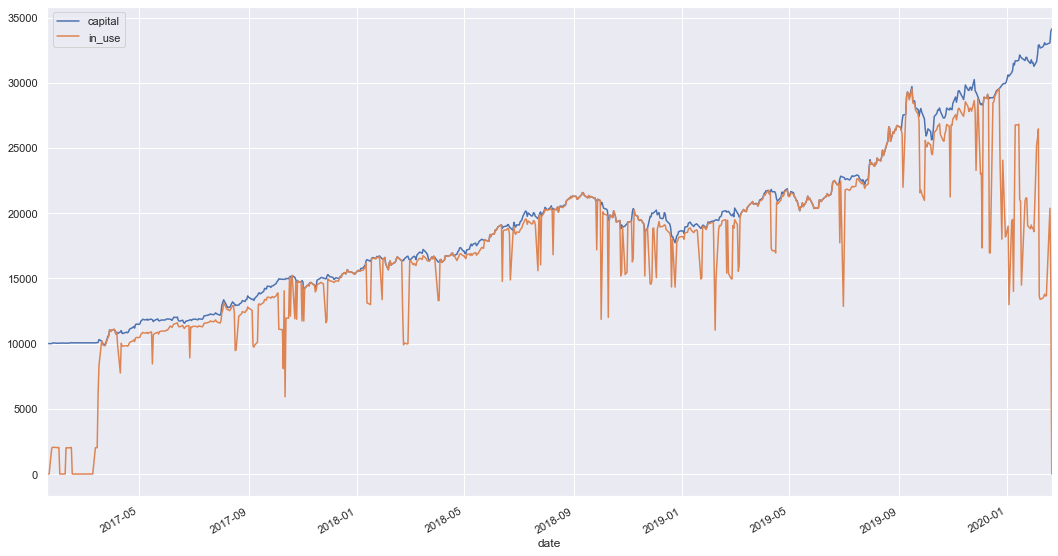

In [6]:
#myPnL_df, my_Capital_df = backtester()
myCapital_df = my_Capital_df
myCapital_df.index = myCapital_df.date
to_plot_cols = ['capital', 'in_use']
myCapital_df[to_plot_cols].plot(figsize=(18,10))
plt.show()